# Pill recognition - recreating fiji prototype

- Split channels and combine (sum) edge detection of all of them
- Threshold using estimated background
- Save masks of reference dataset
- Extract features (todo)
- Rank samples (todo)


In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt #similar to io.imshow(edges), but with more details

In [67]:
from skimage import color, io, morphology, img_as_ubyte, feature, exposure, filters, util

In [68]:
ic = io.ImageCollection("/Users/ushizima/Dropbox/aqui/BIDS/projects/nih_pil/pir-challenge/dr/*.jpg")

In [69]:
pill = ic[158] #this is working :)
print(pill)
#pill = io.imread('/Users/ushizima/Dropbox/aqui/BIDS/projects/nih_pil/pir-challenge/dr/00002-3228-30_PART_1_OF_1_CHAL10_SF_391E1C80.jpg')
pill = img_as_ubyte(pill) #normalize image values
print(pill.min(), pill.max())

[[[118 118 118]
  [118 118 118]
  [118 118 118]
  ..., 
  [118 118 118]
  [118 118 118]
  [118 118 118]]

 [[118 118 118]
  [118 118 118]
  [118 118 118]
  ..., 
  [118 118 118]
  [118 118 118]
  [118 118 118]]

 [[118 118 118]
  [118 118 118]
  [118 118 118]
  ..., 
  [118 118 118]
  [118 118 118]
  [118 118 118]]

 ..., 
 [[118 118 118]
  [118 118 118]
  [118 118 118]
  ..., 
  [118 118 118]
  [118 118 118]
  [118 118 118]]

 [[118 118 118]
  [118 118 118]
  [118 118 118]
  ..., 
  [118 118 118]
  [118 118 118]
  [118 118 118]]

 [[118 118 118]
  [118 118 118]
  [118 118 118]
  ..., 
  [118 118 118]
  [118 118 118]
  [118 118 118]]]
111 221


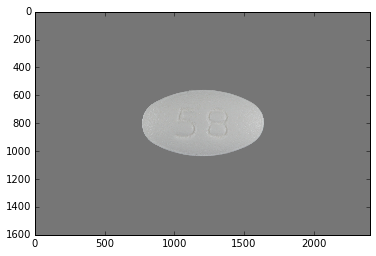

In [70]:
plt.imshow(pill)

In [71]:
print("Type is :",type(pill)," and size is:",pill.shape," - notice it's height per width!!!")

Type is : <class 'numpy.ndarray'>  and size is: (1600, 2400, 3)  - notice it's height per width!!!


In [72]:
#Resize image: notice that x is height and y is width
#1. Reduce Canvas size
h, w, c = pill.shape
x=round(0.15*h);
y=round(0.05*w); #x and y parameters are different from ISVC (.1,.2)
h=h - x;
w=w - y;
croppedPill = pill[x:h,y:w]#(x,y,w,h)))



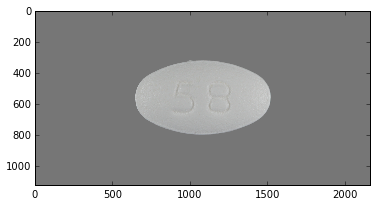

In [73]:
plt.imshow(croppedPill)
#skimage.util.crop(ar, crop_width, copy=False, order='K') doesn't work

In [74]:
#2. Reduce image resolution
shrinkFactor = 0.2

w=round(croppedPill.shape[0]*shrinkFactor)
h=round(croppedPill.shape[1]*shrinkFactor)
from skimage.transform import resize
smallPill= resize(croppedPill,(w,h))

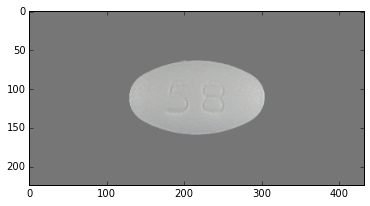

In [75]:
plt.imshow(smallPill)

In [76]:
#Separate channels of the pill
r = smallPill[...,0]
g = smallPill[...,1]
b = smallPill[...,2]
#plt.imshow(r, cmap='gray')

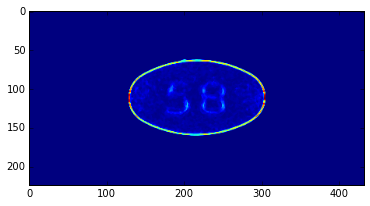

In [77]:
#edgesH = filters.rank.enhance_contrast_percentile(filters.sobel((h)) ,morphology.disk(5),p0=.1,p1=.9)
#edgesH = filters.rank.maximum(    filters.sobel((h)) ,morphology.disk(5))
edgesPill = filters.sobel(r)+filters.sobel(g)+filters.sobel(b) 
edgesPill = edgesPill - edgesPill.min()
edgesPill = edgesPill / edgesPill.max()
edgesPill = edgesPill*255;
from skimage.morphology import disk
from skimage.filters.rank import mean
from scipy import ndimage as ndi
smoothPill = ndi.median_filter(edgesPill.astype(np.uint16), 3)
#smoothPill = mean(edgesPill.astype(np.uint16), disk(3))
plt.imshow(smoothPill)

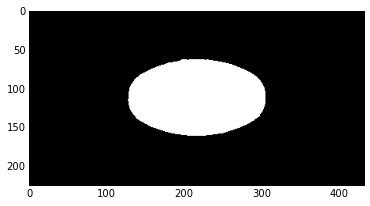

In [78]:
binPill = (smoothPill>smoothPill.min()) 
binPill = ndi.binary_fill_holes(binPill)
plt.imshow(binPill,cmap='gray')


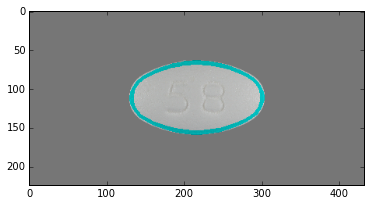

In [79]:
from skimage.color import rgb2gray
boundary = morphology.binary_dilation(feature.canny(binPill), morphology.disk(2))
boundary = boundary > 0

pill_vis = smallPill.copy()
pill_grayscale = rgb2gray(smallPill)
pill_vis[boundary, 0] = 255
plt.imshow(pill_vis)

In [80]:
#String manipulation
filename = ic.files[1]
a=filename.split('/')
print(a[-1])

00002-3228-30_PART_1_OF_1_CHAL10_SF_391E1C80.jpg


In [81]:
from skimage.measure import label, regionprops
regions = regionprops(binPill,pill_grayscale) #notice that you need to also 

In [82]:
len(regions)

1

In [83]:
#Print all the properties for a region
for p in regions[0]:
    print(p)
    
# these are the features you are looking for [0,-3]

major_axis_length
moments_normalized
moments
filled_image
centroid
moments_hu
minor_axis_length
mean_intensity
weighted_moments_normalized
weighted_moments_central
euler_number
max_intensity
eccentricity
orientation
weighted_moments
weighted_moments_hu
area
solidity
extent
weighted_centroid
convex_area
label
coords
equivalent_diameter
moments_central
min_intensity
filled_area
bbox
perimeter
image
convex_image


In [84]:
#This will construct a dictionary containing only the features not included in the sequence on the right of the command
{p:regions[0][p] for p in regions[0] if p not in ('image','convex_image','filled_image')}

{'area': 13810.0,
 'bbox': (63, 127, 161, 304),
 'centroid': (111.55126719768285, 215.4421433743664),
 'convex_area': 13946,
 'coords': array([[ 63, 196],
        [ 63, 197],
        [ 63, 198],
        ..., 
        [160, 225],
        [160, 226],
        [160, 227]]),
 'eccentricity': 0.8377853203382872,
 'equivalent_diameter': 132.60255696174414,
 'euler_number': 0,
 'extent': 0.79614896806180102,
 'filled_area': 13810,
 'label': 1,
 'major_axis_length': 179.4800583924154,
 'max_intensity': 0.83334470588235121,
 'mean_intensity': 0.69863182178302163,
 'min_intensity': 0.45882352941176513,
 'minor_axis_length': 97.99607194722657,
 'moments': array([[  1.38100000e+04,   6.70493000e+05,   4.08424210e+07,
           2.78712758e+09],
        [  1.22138600e+06,   5.92174050e+07,   3.60421819e+09,
           2.45827970e+11],
        [  1.35825572e+08,   6.58232573e+09,   3.95122063e+11,
           2.65273593e+13],
        [  1.69305313e+10,   8.20349425e+11,   4.84796913e+13,
           3.

In [85]:
#Remove whatever is not a scalar or list
all_props = {p:regions[0][p] for p in regions[0] if p not in ('image','convex_image','filled_image')}

for p, v in list(all_props.items()):
    if isinstance(v,np.ndarray):
        if(len(v.shape)>1):
            del all_props[p]
            
for p, v in list(all_props.items()):
    try:
        L = len(v)
    except:
        L = 1
    if L>1:
        del all_props[p]
        for n,entry in enumerate(v):
            all_props[p + str(n)] = entry
print(all_props)        

{'solidity': 0.99024809981356665, 'minor_axis_length': 97.99607194722657, 'max_intensity': 0.83334470588235121, 'eccentricity': 0.8377853203382872, 'min_intensity': 0.45882352941176513, 'weighted_moments_hu1': 0.02237110421665181, 'moments_hu1': 0.010470525328790045, 'area': 13810.0, 'euler_number': 0, 'weighted_centroid1': 216.16219485645871, 'weighted_moments_hu6': -1.6644510249828897e-13, 'bbox2': 161, 'equivalent_diameter': 132.60255696174414, 'centroid1': 215.4421433743664, 'weighted_moments_hu2': 2.3748708604800513e-06, 'bbox3': 304, 'filled_area': 13810, 'moments_hu0': 0.18924837743315914, 'weighted_centroid0': 111.36849455229738, 'extent': 0.79614896806180102, 'orientation': 0.004224106664591486, 'centroid0': 111.55126719768285, 'moments_hu6': 3.6822432835282968e-17, 'moments_hu2': 1.2533511213230645e-07, 'major_axis_length': 179.4800583924154, 'bbox0': 63, 'weighted_moments_hu3': 4.1179230060763988e-06, 'label': 1, 'convex_area': 13946, 'weighted_moments_hu5': 5.77318927925349

In [86]:
all_props.values()

dict_values([0.99024809981356665, 97.99607194722657, 0.83334470588235121, 0.8377853203382872, 0.45882352941176513, 0.02237110421665181, 0.010470525328790045, 13810.0, 0, 216.16219485645871, -1.6644510249828897e-13, 161, 132.60255696174414, 215.4421433743664, 2.3748708604800513e-06, 304, 13810, 0.18924837743315914, 111.36849455229738, 0.79614896806180102, 0.004224106664591486, 111.55126719768285, 3.6822432835282968e-17, 1.2533511213230645e-07, 179.4800583924154, 63, 4.1179230060763988e-06, 1, 13946, 5.7731892792534941e-07, -1.4745954187049429e-16, 0.26879137759012661, 127, 1.2876595510319447e-11, 0.69863182178302163, 470.33304448274089, 5.6909011991632252e-09, -5.7124291568829807e-10])

In [87]:
all_props.keys()

dict_keys(['solidity', 'minor_axis_length', 'max_intensity', 'eccentricity', 'min_intensity', 'weighted_moments_hu1', 'moments_hu1', 'area', 'euler_number', 'weighted_centroid1', 'weighted_moments_hu6', 'bbox2', 'equivalent_diameter', 'centroid1', 'weighted_moments_hu2', 'bbox3', 'filled_area', 'moments_hu0', 'weighted_centroid0', 'extent', 'orientation', 'centroid0', 'moments_hu6', 'moments_hu2', 'major_axis_length', 'bbox0', 'weighted_moments_hu3', 'label', 'convex_area', 'weighted_moments_hu5', 'moments_hu4', 'weighted_moments_hu0', 'bbox1', 'weighted_moments_hu4', 'mean_intensity', 'perimeter', 'moments_hu3', 'moments_hu5'])

#Sort values by key, so that related features are more likely to be close to each other

In [102]:
d=sorted(all_props.items())
print(type(d))

<class 'list'>


In [103]:
for k, v in d:
    print( k, v)

area 13810.0
bbox0 63
bbox1 127
bbox2 161
bbox3 304
centroid0 111.551267198
centroid1 215.442143374
convex_area 13946
eccentricity 0.8377853203382872
equivalent_diameter 132.60255696174414
euler_number 0
extent 0.796148968062
filled_area 13810
label 1
major_axis_length 179.4800583924154
max_intensity 0.833344705882
mean_intensity 0.698631821783
min_intensity 0.458823529412
minor_axis_length 97.99607194722657
moments_hu0 0.189248377433
moments_hu1 0.0104705253288
moments_hu2 1.25335112132e-07
moments_hu3 5.69090119916e-09
moments_hu4 -1.4745954187e-16
moments_hu5 -5.71242915688e-10
moments_hu6 3.68224328353e-17
orientation 0.004224106664591486
perimeter 470.333044483
solidity 0.990248099814
weighted_centroid0 111.368494552
weighted_centroid1 216.162194856
weighted_moments_hu0 0.26879137759
weighted_moments_hu1 0.0223711042167
weighted_moments_hu2 2.37487086048e-06
weighted_moments_hu3 4.11792300608e-06
weighted_moments_hu4 1.28765955103e-11
weighted_moments_hu5 5.77318927925e-07
weighte

In [105]:
import collections
od = collections.OrderedDict(sorted(all_props.items()))
for k, v in list(od.items()): 
    print (k, v)

area 13810.0
bbox0 63
bbox1 127
bbox2 161
bbox3 304
centroid0 111.551267198
centroid1 215.442143374
convex_area 13946
eccentricity 0.8377853203382872
equivalent_diameter 132.60255696174414
euler_number 0
extent 0.796148968062
filled_area 13810
label 1
major_axis_length 179.4800583924154
max_intensity 0.833344705882
mean_intensity 0.698631821783
min_intensity 0.458823529412
minor_axis_length 97.99607194722657
moments_hu0 0.189248377433
moments_hu1 0.0104705253288
moments_hu2 1.25335112132e-07
moments_hu3 5.69090119916e-09
moments_hu4 -1.4745954187e-16
moments_hu5 -5.71242915688e-10
moments_hu6 3.68224328353e-17
orientation 0.004224106664591486
perimeter 470.333044483
solidity 0.990248099814
weighted_centroid0 111.368494552
weighted_centroid1 216.162194856
weighted_moments_hu0 0.26879137759
weighted_moments_hu1 0.0223711042167
weighted_moments_hu2 2.37487086048e-06
weighted_moments_hu3 4.11792300608e-06
weighted_moments_hu4 1.28765955103e-11
weighted_moments_hu5 5.77318927925e-07
weighte

In [108]:
#save measurements to a csv file
k = ", ".join(od.keys())
v = ", ".join([str(f) for f in od.values()]) #notice you need to convert numbers to strings
with open('dict.csv','w') as f:
        #f.write(k)
        f.writelines([k,'\n',v])        


In [89]:
#http://fenyolab.org/ibb2014/tutorials/week14/basic_image_analysis.py
output_file = open('image_measurements.csv', 'w')
type(regions)
for props in regions:
    print(props.area)

regions.    
    #output_file.write(',' + ",".join(props) + '\n')    

SyntaxError: invalid syntax (<ipython-input-89-4c5292b2bc78>, line 7)

#Implementation used to generate mask dataset

In [ ]:
def pillSegmentation(pillPicture):
    pill = img_as_ubyte(pillPicture) #normalize image values

    #Resize image: notice that x is height and y is width
    #1. Reduce Canvas size based on prior info about this database
    h, w, c = pill.shape
    x=round(0.15*h);
    y=round(0.05*w); #x and y parameters are different from ISVC (.2,.1)
    h=h - x;
    w=w - y;
    croppedPill = pill[x:h,y:w]#(x,y,w,h)))

    #2. Reduce image size
    from skimage.transform import resize
    shrinkFactor = 0.2
    w=round(croppedPill.shape[0]*shrinkFactor)
    h=round(croppedPill.shape[1]*shrinkFactor)
    smallPill= resize(croppedPill,(w,h))

    #3. Separate channels of the pill
    r = smallPill[...,0]
    g = smallPill[...,1]
    b = smallPill[...,2]

    #4. Multiband sobel, combine channels and filter
    edgesPill = filters.sobel(r)+filters.sobel(g)+filters.sobel(b)
    edgesPill = edgesPill - edgesPill.min()
    edgesPill = edgesPill / edgesPill.max()
    edgesPill = edgesPill*255;

    from skimage.filters.rank import mean
    from scipy import ndimage as ndi
    smoothPill = ndi.median_filter(edgesPill.astype(np.uint16), 3)
    #smoothPill = mean(edgesPill.astype(np.uint16), morphology.disk(3))
    #plt.imshow(smoothPill)
    binPill = (smoothPill>smoothPill.min())
    binPill = ndi.binary_fill_holes(binPill)
    return (255*binPill).astype(np.uint8)


In [ ]:
#Run for the whole database
ic = io.ImageCollection("/Users/ushizima/Dropbox/aqui/BIDS/projects/nih_pil/pir-challenge/dr/*.jpg")
#check a subset first ic[:1]
for n, pillPicture in enumerate(ic[:1]):
    mask = pillSegmentation(pillPicture)
    #io.imsave('output/boundary_%03d.png' % n, mask)
    path = ic.files[n]
    pathPieces=path.split('/')
    pathPieces2=pathPieces[-1].split('.')
    filename='output/'+pathPieces2[0]+'.png'
    io.imsave(filename, mask) #how to save mask with the same filename
    #plt.imshow(smoothPill)
print("Done")
    